In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from utils import plot_boxplot, get_seasonality_trend_overview, plot_period_mean, plot_periodogram
import warnings
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [38]:
# Import
df_train = pd.read_csv('originalni_datasetovi/train.csv')
df_test = pd.read_csv('originalni_datasetovi/test.csv')
df_stores = pd.read_csv('originalni_datasetovi/stores.csv')
df_oil = pd.read_csv('originalni_datasetovi/oil.csv')
df_holidays = pd.read_csv('originalni_datasetovi/holidays_events.csv')
df_transactions = pd.read_csv('originalni_datasetovi/transactions.csv').sort_values(['store_nbr', 'date'])

## Oil
Oil data contains only two attributes: **Date** and **dcoilwtico**(oil price for a given day).

In [39]:
df_oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [40]:
df_oil.rename(columns={'dcoilwtico': 'oil_price'}, inplace=True) # change column name for readability
df_oil['date'] = pd.to_datetime(df_oil.date)
df_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       1218 non-null   datetime64[ns]
 1   oil_price  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


There are no data about oil prices on weekends so we use linear interpolation for those dates. \
Linear interpolation ignores the index and treat the values as equally spaced.

In [41]:
df_oil.loc[df_oil['date'] == '2013-01-01', 'oil_price'] = 93.14 # since linear interpolation doesnt work on data thats not between data points we use 2nd data point as 1st data point
df_oil = df_oil.interpolate(method='linear', limit=20)
df_oil.describe()

,date,oil_price
count,1218,1218.000000
mean,2015-05-02 12:00:00,67.682742
min,2013-01-01 00:00:00,26.190000
25%,2014-03-03 06:00:00,46.422500
50%,2015-05-02 12:00:00,53.185000
75%,2016-06-30 18:00:00,95.685000
max,2017-08-31 00:00:00,110.620000
std,NaN,25.632933


We see 2 peaks on distribution plot, one for data before 2015 and one for data after 2015.

Text(0.5, 1.0, 'Distribution : Oil Price')

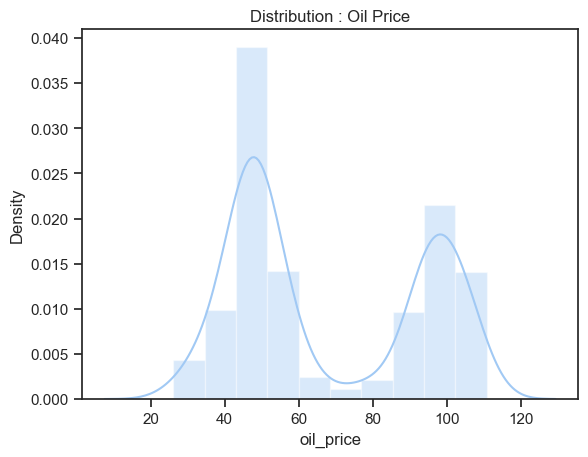

In [42]:
sns.distplot(df_oil['oil_price'])
plt.title('Distribution : Oil Price')

Text(0, 0.5, 'Oil Price')

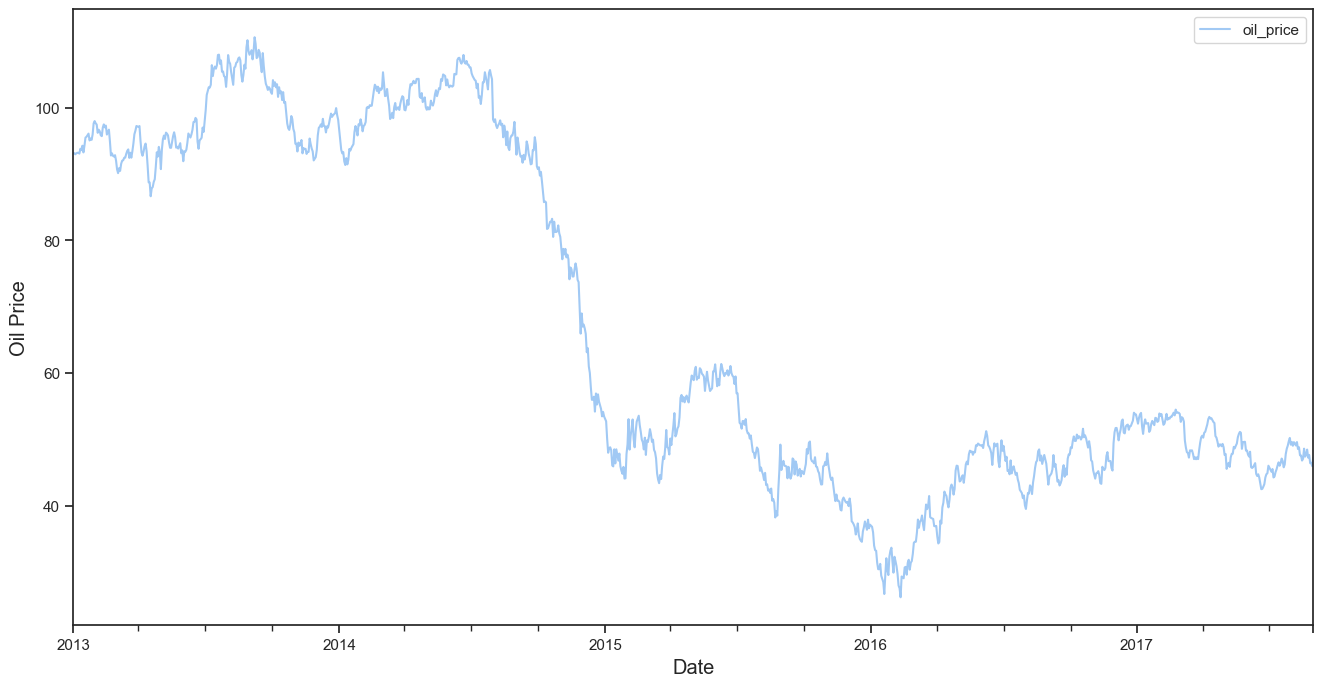

In [43]:
ax = df_oil.set_index('date').plot(figsize = (16, 8))
ax.set_xlabel('Date', fontsize = 'large')
ax.set_ylabel('Oil Price', fontsize = 'large')

Dip in mid-2014 to early 2015 was primarily driven by supply factors, including booming U.S. oil production, receding geopolitical concerns, and shifting OPEC policies. \
In November 2014, OPEC announced a new strategy geared towards improving its market share. Oil-market analysts interpreted this as an attempt to squeeze higher-cost \
producers including US shale oil out of the market. Over the next year, crude oil prices crashed, with large repercussions for the global economy.

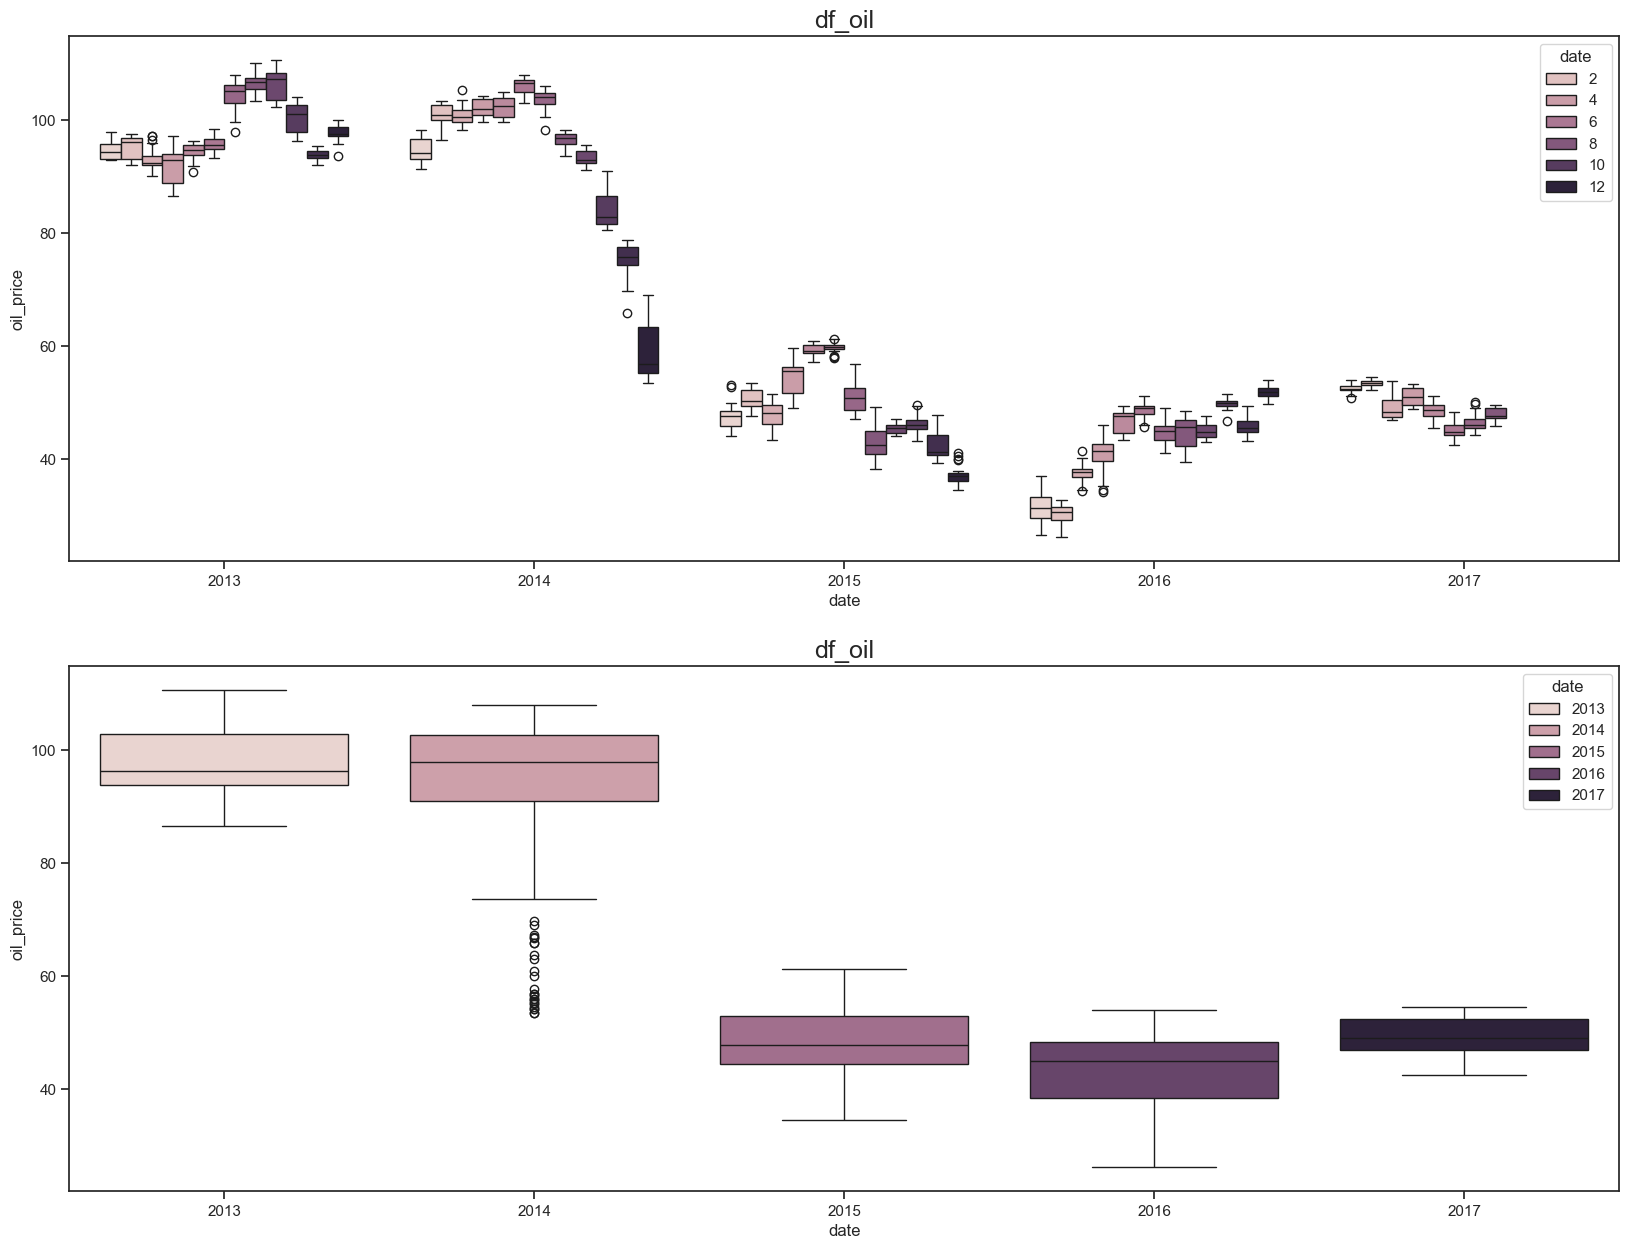

In [44]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,15))
plot_boxplot('pastel', df_oil['date'].dt.year, df_oil['oil_price'], df_oil['date'].dt.month, axes[0], 'df_oil')
plot_boxplot('pastel', df_oil['date'].dt.year, df_oil['oil_price'], df_oil['date'].dt.year, axes[1], 'df_oil')

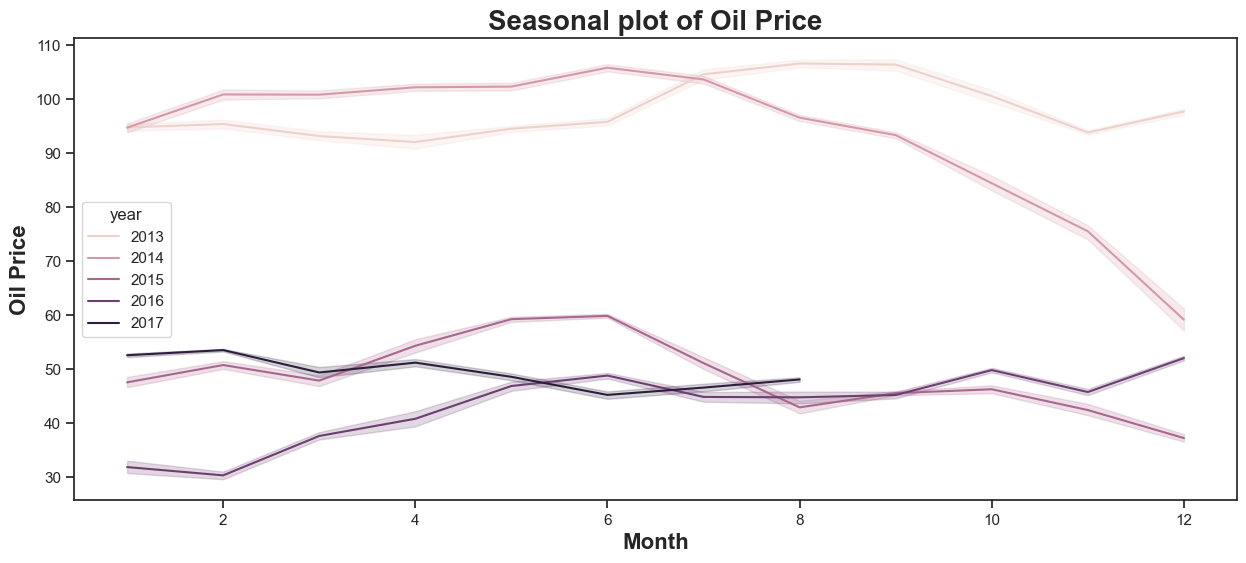

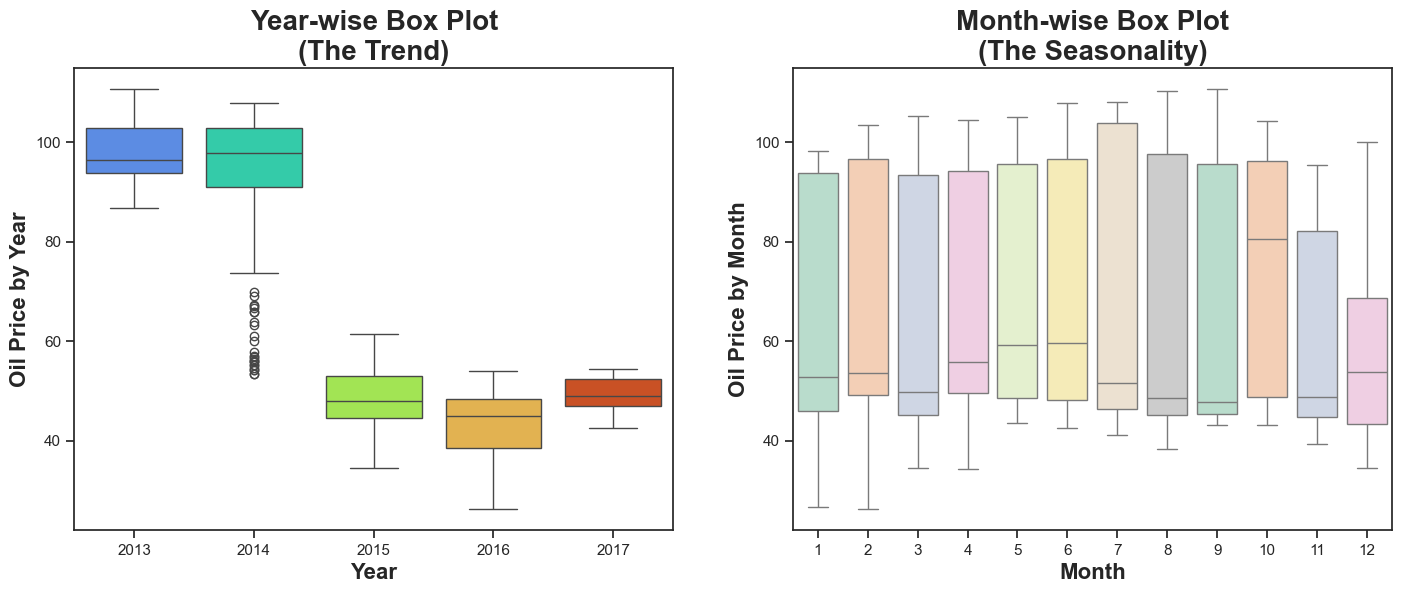

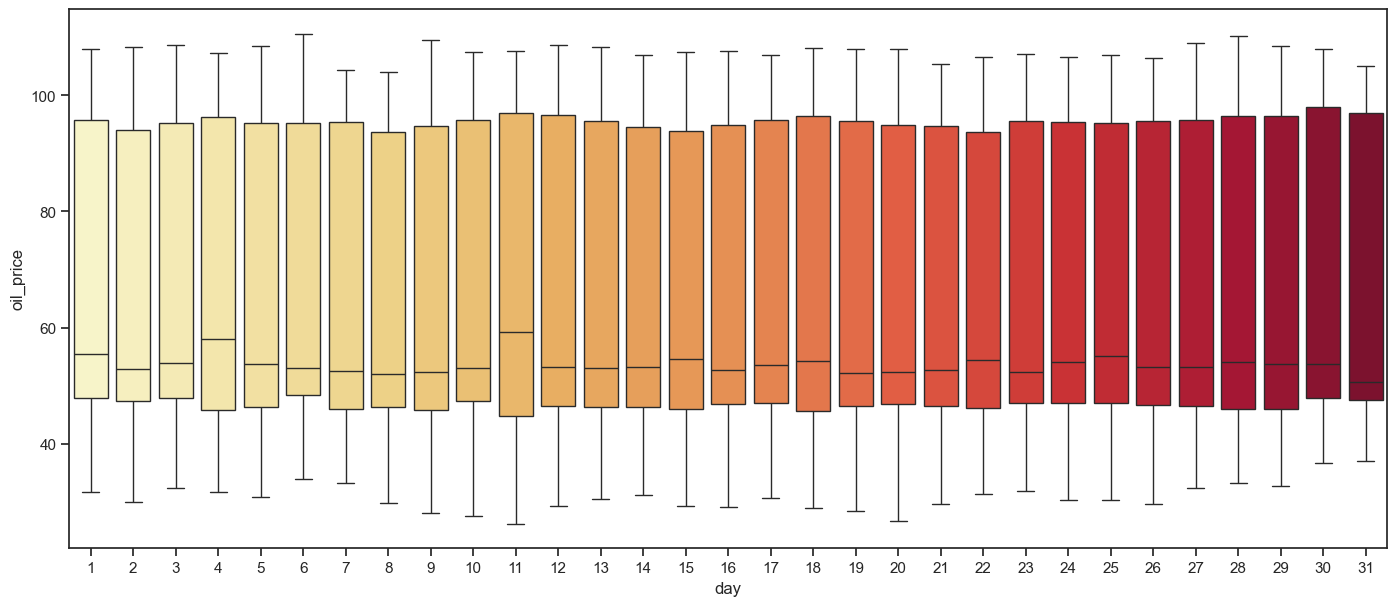

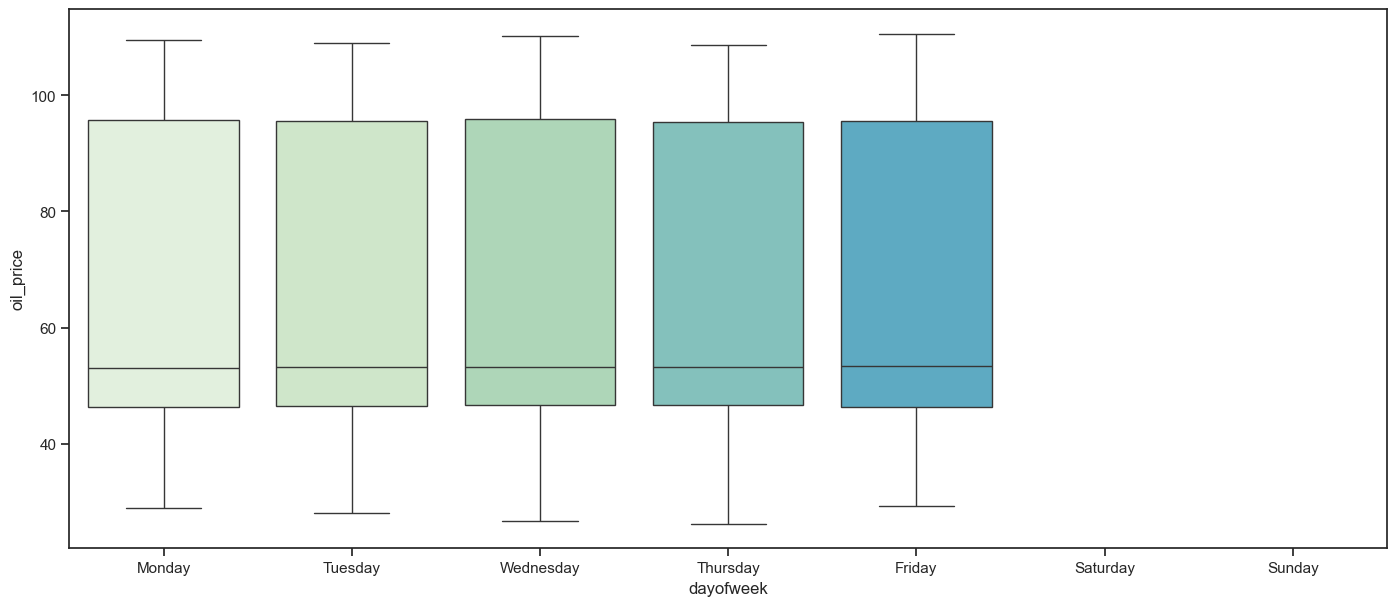

In [45]:
get_seasonality_trend_overview(df_oil, 'oil_price', title_name='Oil Price')

## Transactions
Transaction data contains 3 attributes: **date**, **store_nbr** (store number where transactions took place) and **transactions** (number of transactions on a given date in a specified store).

In [46]:
df_transactions.head()

,date,store_nbr,transactions
1,2013-01-02,1,2111
47,2013-01-03,1,1833
93,2013-01-04,1,1863
139,2013-01-05,1,1509
185,2013-01-06,1,520


In [47]:
df_transactions['date'] = pd.to_datetime(df_transactions.date)
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83488 entries, 1 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 2.5 MB


Transaction data is right skewed -> potencial log transform

Text(0.5, 1.0, 'Distribution : Transactions')

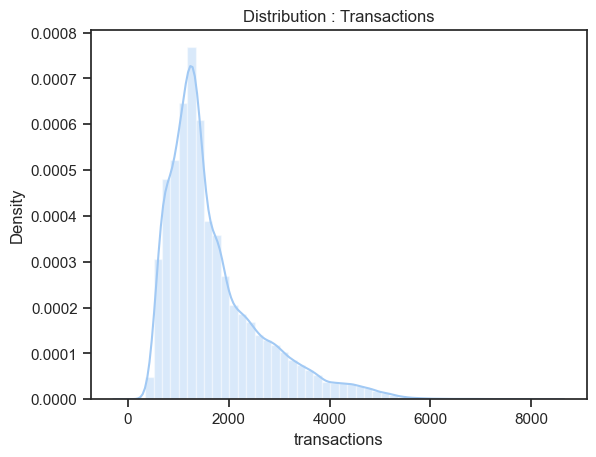

In [48]:
sns.distplot(df_transactions['transactions'])
plt.title('Distribution : Transactions')

       transactions
month              
1          12156198
2          11707934
3          12917913
4          12633531
5          13112679
6          12482179
7          12827206
8          11545571
9           9811819
10         10048234
11          9877873
12         12357808
      transactions
year              
2013      29107173
2014      30006929
2015      31312370
2016      31052337
2017      20000136
            transactions
year month              
2013 1           2289558
     2           2169615
     3           2458683
     4           2344905
     5           2467465
     6           2392206
     7           2401968
     8           2461139
     9           2380462
     10          2408440
     11          2369866
     12          2962866
2014 1           2393528
     2           2278167
     3           2545427
     4           2455666
     5           2503262
     6           2399144
     7           2442341
     8           2537572
     9           2449131
     10     

Text(0, 0.5, 'Transactions')

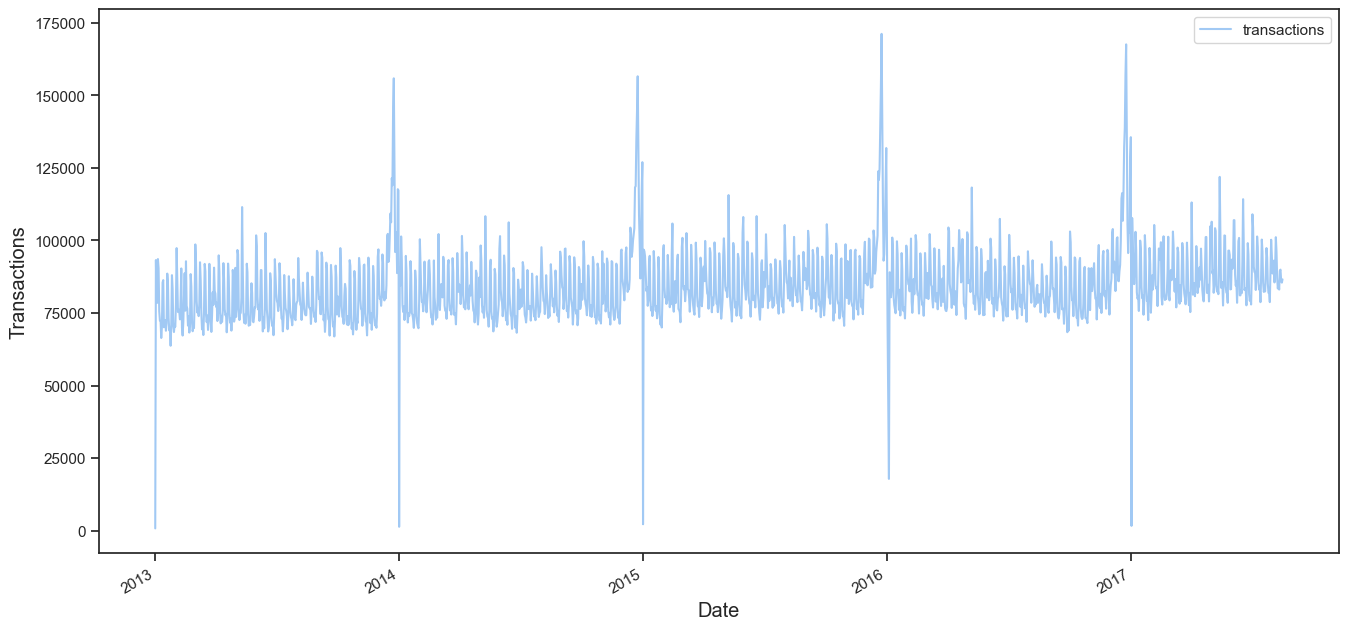

In [49]:
ax = df_transactions.groupby(['date'])[['transactions']].sum().plot(figsize = (16, 8))
df_transactions_copy = df_transactions.copy()
df_transactions_copy['year'] = df_transactions.date.dt.year
df_transactions_copy['month'] = df_transactions.date.dt.month
print(df_transactions_copy.groupby(['month'])[['transactions']].sum())
print(df_transactions_copy.groupby(['year'])[['transactions']].sum())
print(df_transactions_copy.groupby(['year', 'month'])[['transactions']].sum())
ax.set_xlabel('Date', fontsize = 'large')
ax.set_ylabel('Transactions', fontsize = 'large')

Every year transactions peak in December

Spearman Correlation between Total Sales and Transactions: 0.8175


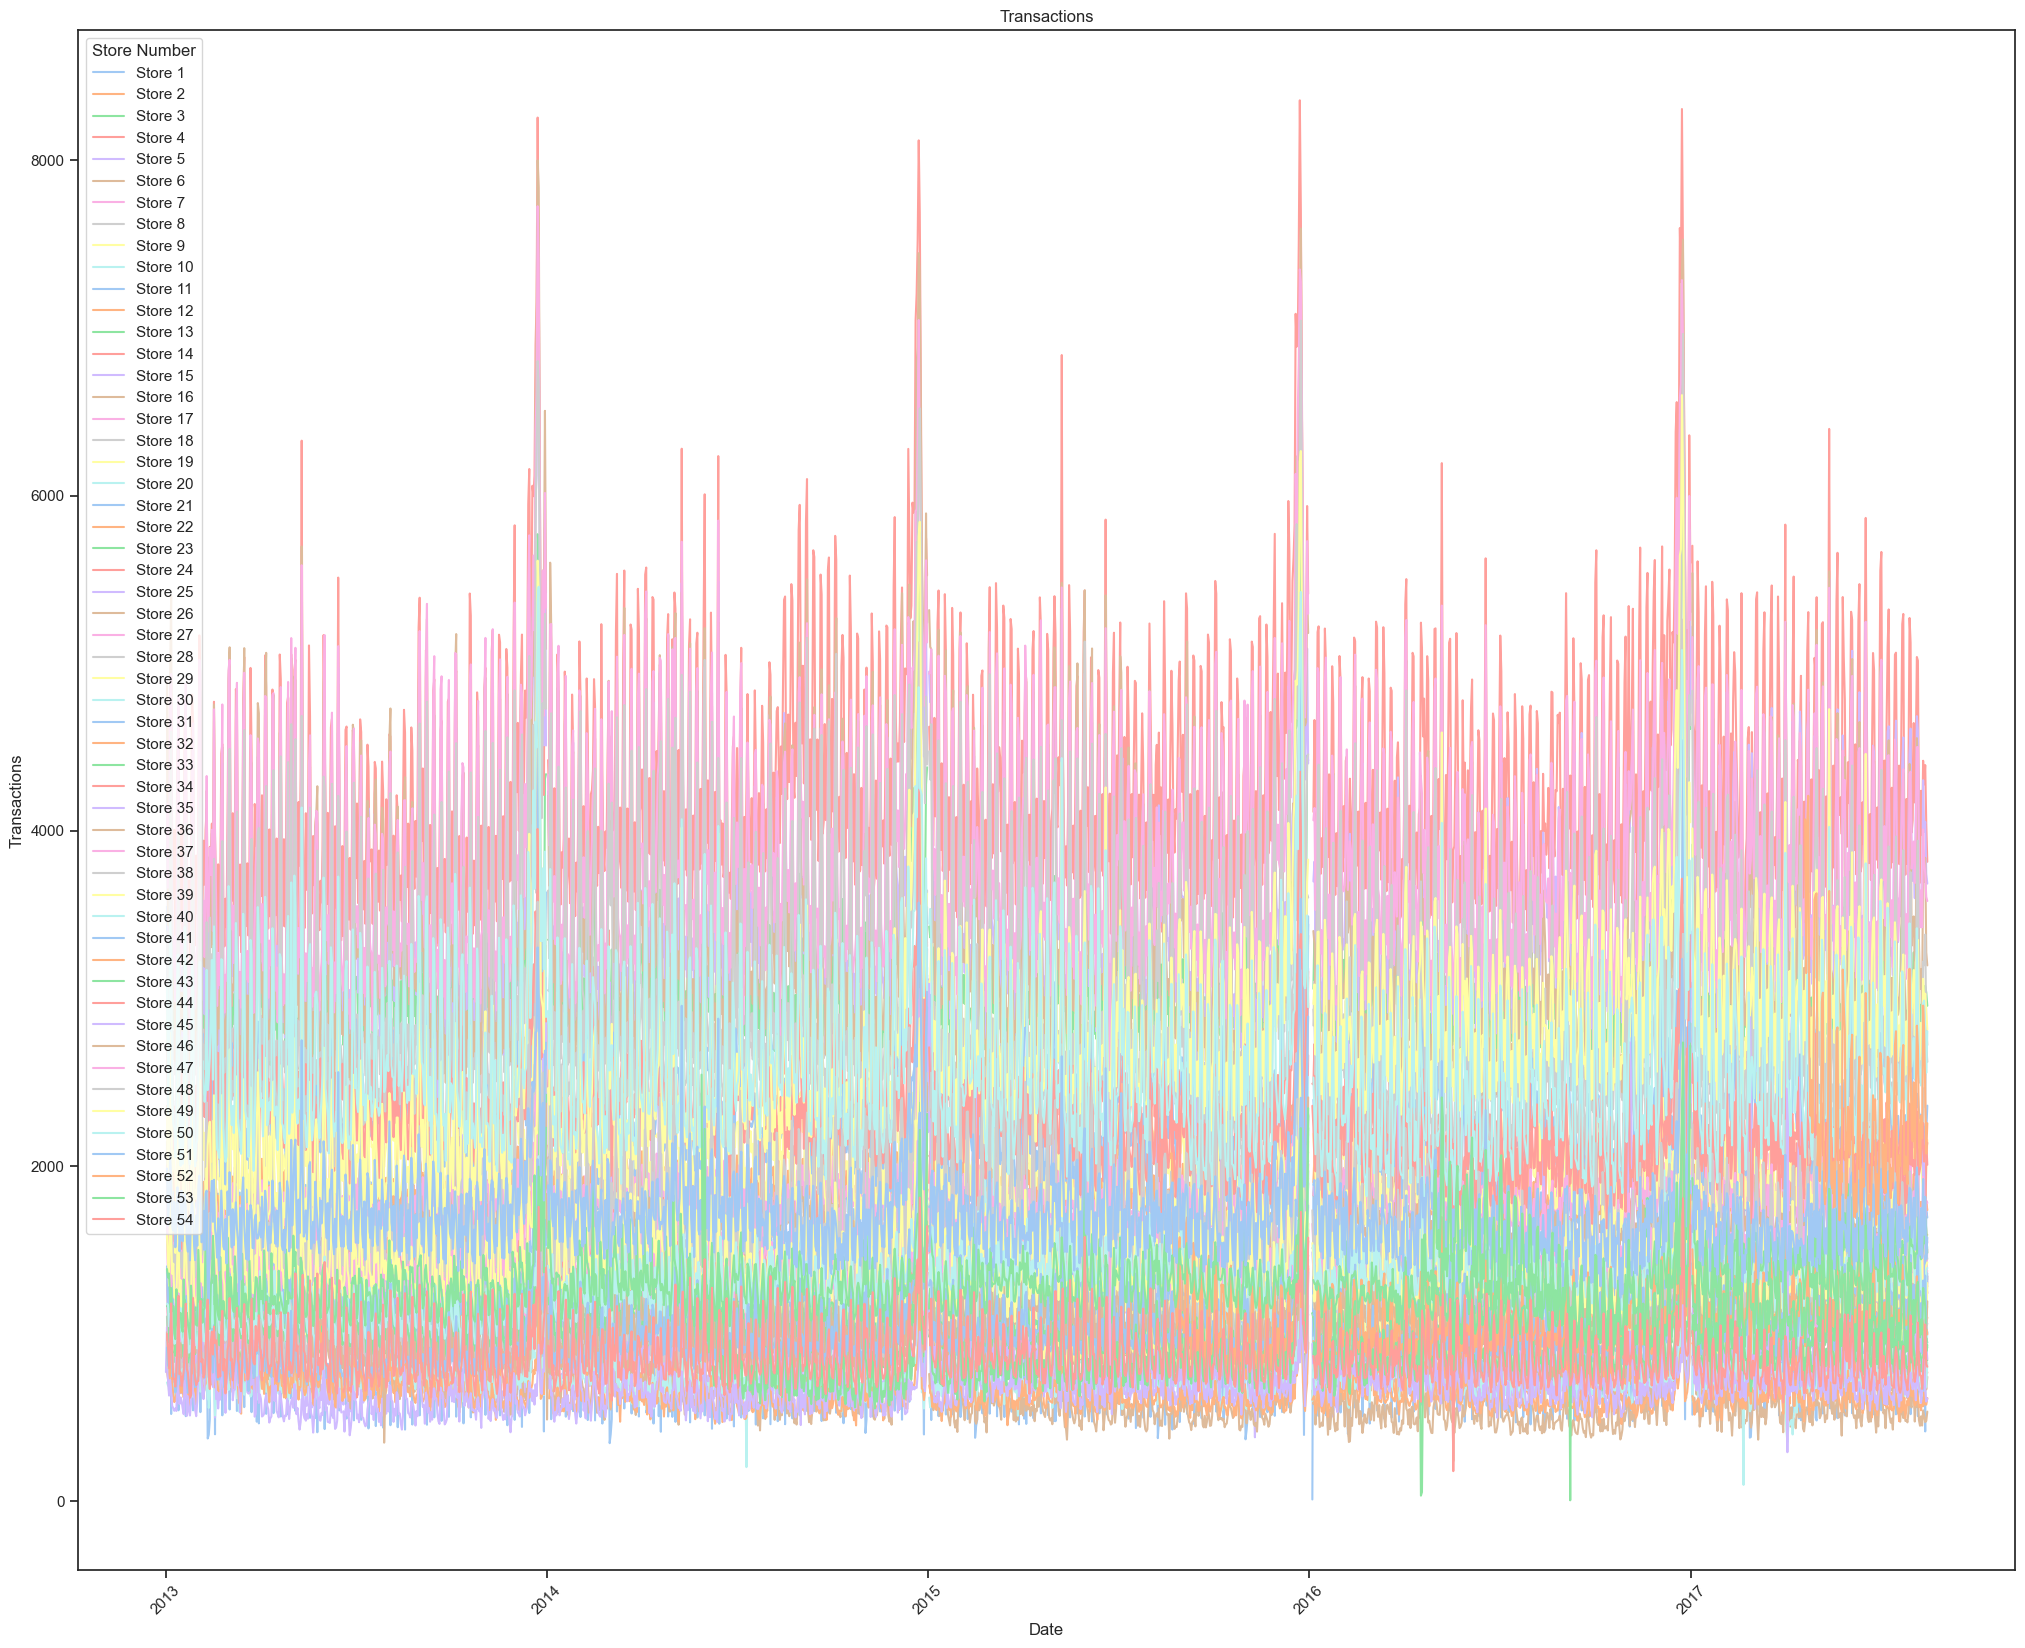

In [50]:
df_train['date'] = pd.to_datetime(df_train.date)

# merge train data and transactions data to check transaction/sales correlation
temp = pd.merge(df_train.groupby(['date', 'store_nbr']).sales.sum().reset_index(), df_transactions, how = 'left')
print('Spearman Correlation between Total Sales and Transactions: {:,.4f}'.format(temp.corr('spearman').sales.loc['transactions']))

transactions_sorted = temp.sort_values(['store_nbr', 'date'])

# Create a figure and an axis
fig, ax = plt.subplots(figsize=(25, 20))

# Plot each store's transactions
for store_nbr, data in transactions_sorted.groupby('store_nbr'):
    ax.plot(data['date'], data['transactions'], label=f'Store {store_nbr}')

# Set the title and labels
ax.set_title('Transactions')
ax.set_xlabel('Date')
ax.set_ylabel('Transactions')
ax.legend(title='Store Number')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)
plt.show()


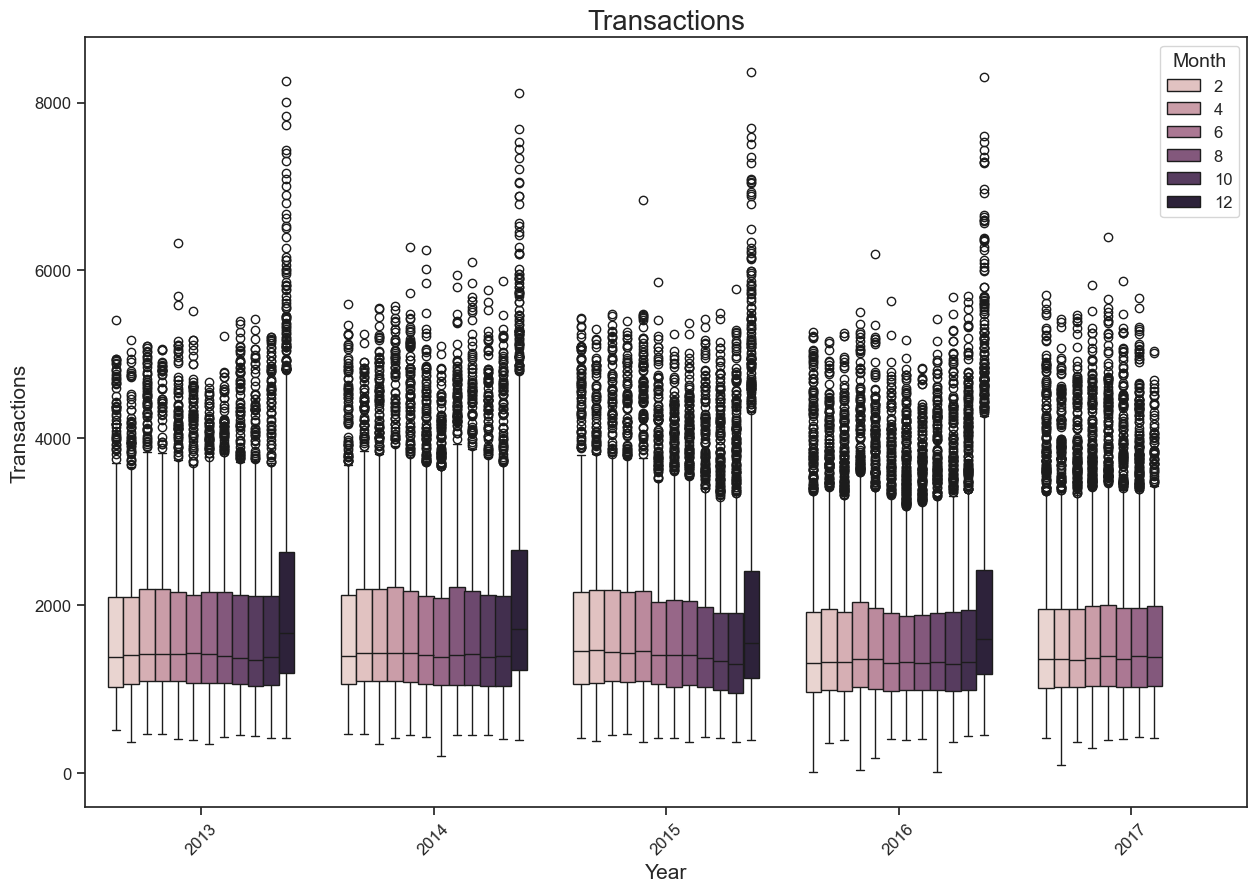

In [51]:
temp = df_transactions.copy()
temp['year'] = temp.date.dt.year
temp['month'] = temp.date.dt.month
plt.figure(figsize=(15, 10))

# Create a boxplot with Seaborn
sns.boxplot(data=temp, x='year', y='transactions', hue='month')

# Set the title and labels
plt.title('Transactions', fontsize=20)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Transactions', fontsize=15)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

plt.legend(title='Month', fontsize=12, title_fontsize=14)
plt.show()

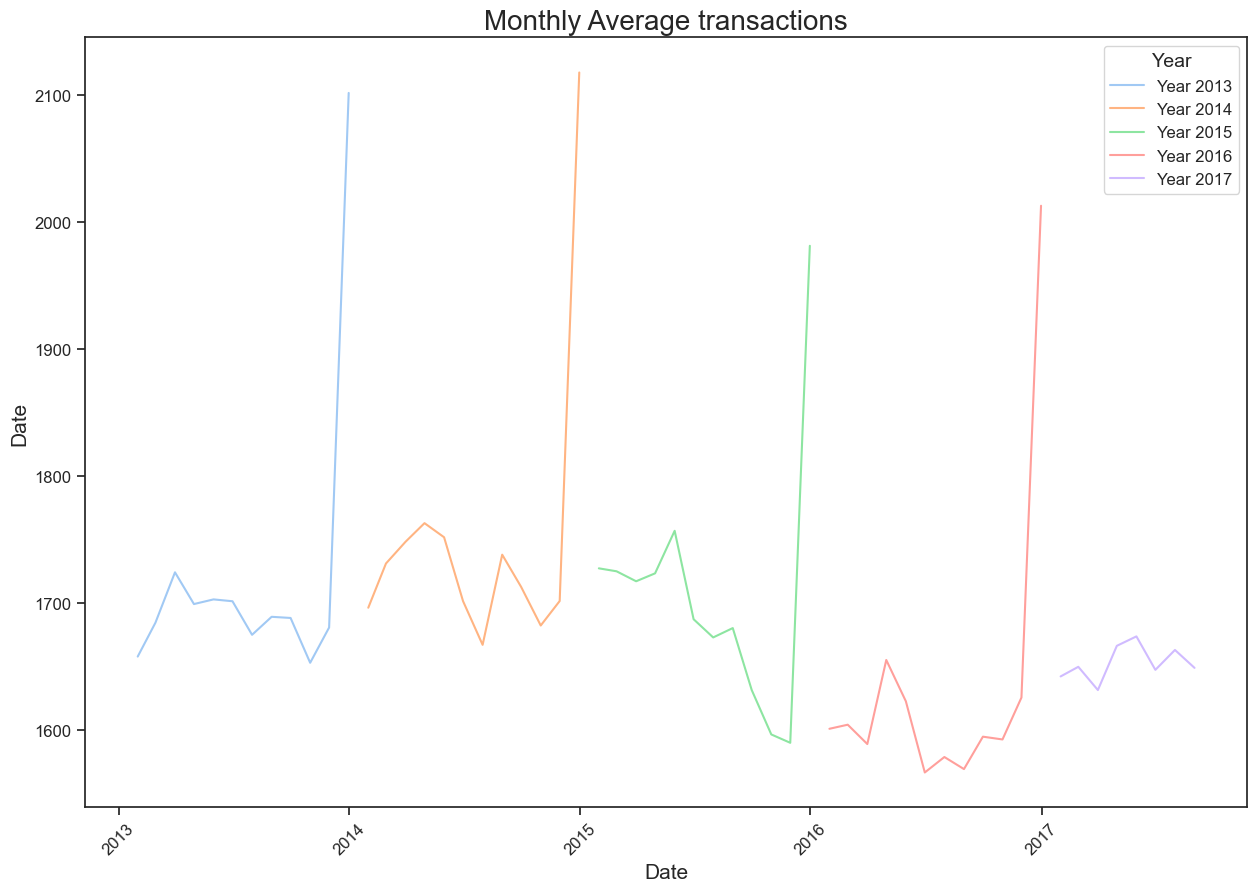

In [52]:
plot_period_mean(df_transactions, 'transactions', period='M')

Highest number of transactions are during weekends with a peak on Saturday

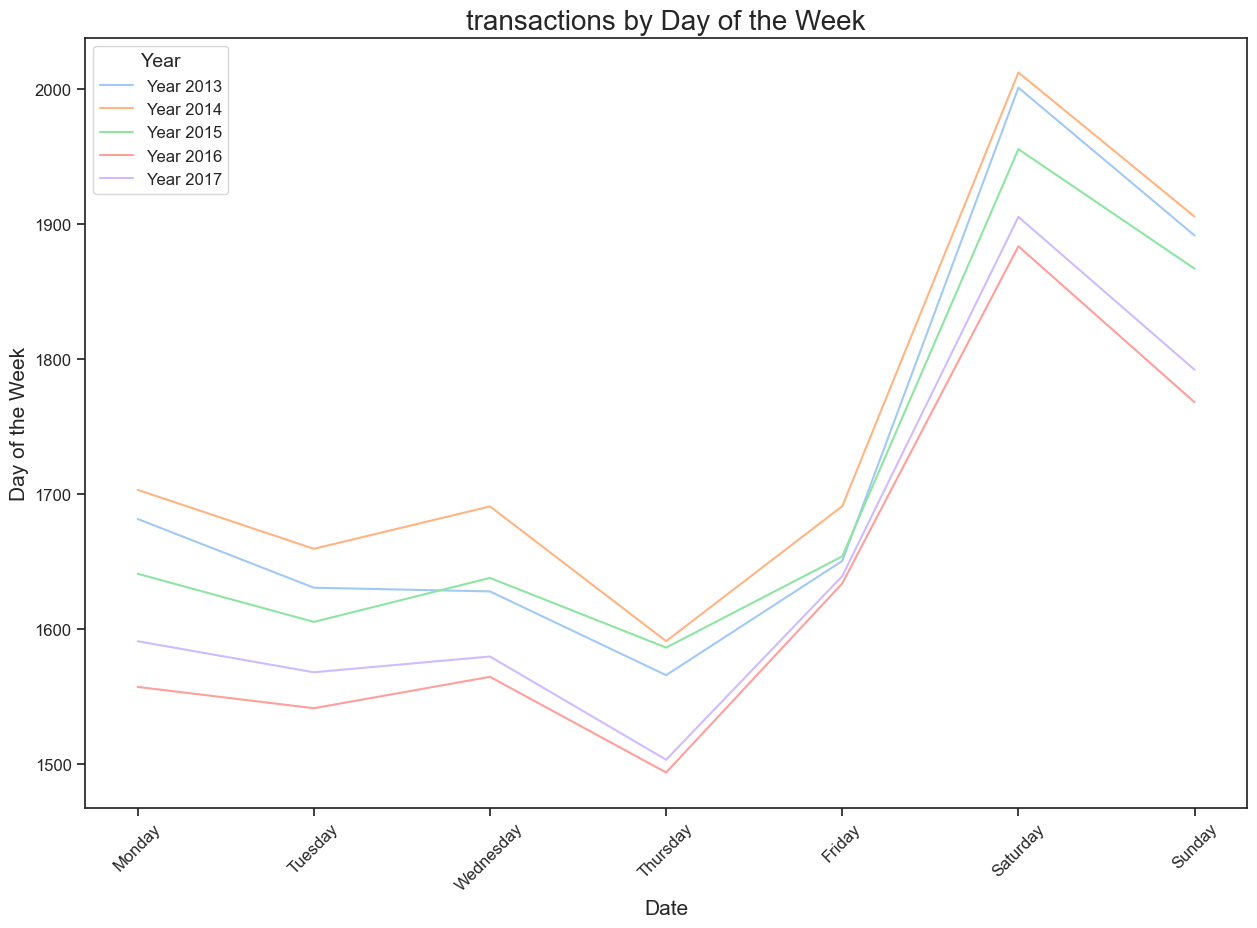

In [53]:
plot_period_mean(df_transactions, 'transactions', period='DW')

## Stores
Stores data contains 5 attributes: **store_nbr**, **city**, **state**, **type**, **cluster**.

In [54]:
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [55]:
df_stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [56]:
df_stores['city'].value_counts()

city
Quito            18
Guayaquil         8
Cuenca            3
Santo Domingo     3
Manta             2
Latacunga         2
Machala           2
Ambato            2
Quevedo           1
Esmeraldas        1
Loja              1
Libertad          1
Playas            1
Daule             1
Babahoyo          1
Salinas           1
Puyo              1
Guaranda          1
Ibarra            1
Riobamba          1
Cayambe           1
El Carmen         1
Name: count, dtype: int64

In [57]:
df_stores['type'].value_counts()

type
D    18
C    15
A     9
B     8
E     4
Name: count, dtype: int64

## Holidays

In [58]:
df_holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [59]:
df_holidays['date'] = pd.to_datetime(df_holidays.date)
df_holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [60]:
df_holidays.describe(include='O')

,type,locale,locale_name,description
count,350,350,350,350
unique,6,3,24,103
top,Holiday,National,Ecuador,Carnaval
freq,221,174,174,10


In [61]:
set(df_holidays.type.to_list())

{'Additional', 'Bridge', 'Event', 'Holiday', 'Transfer', 'Work Day'}

In [62]:
set(df_holidays.locale.to_list())

{'Local', 'National', 'Regional'}

<Axes: title={'center': 'Counts of type of holiday'}, xlabel='locale', ylabel='count'>

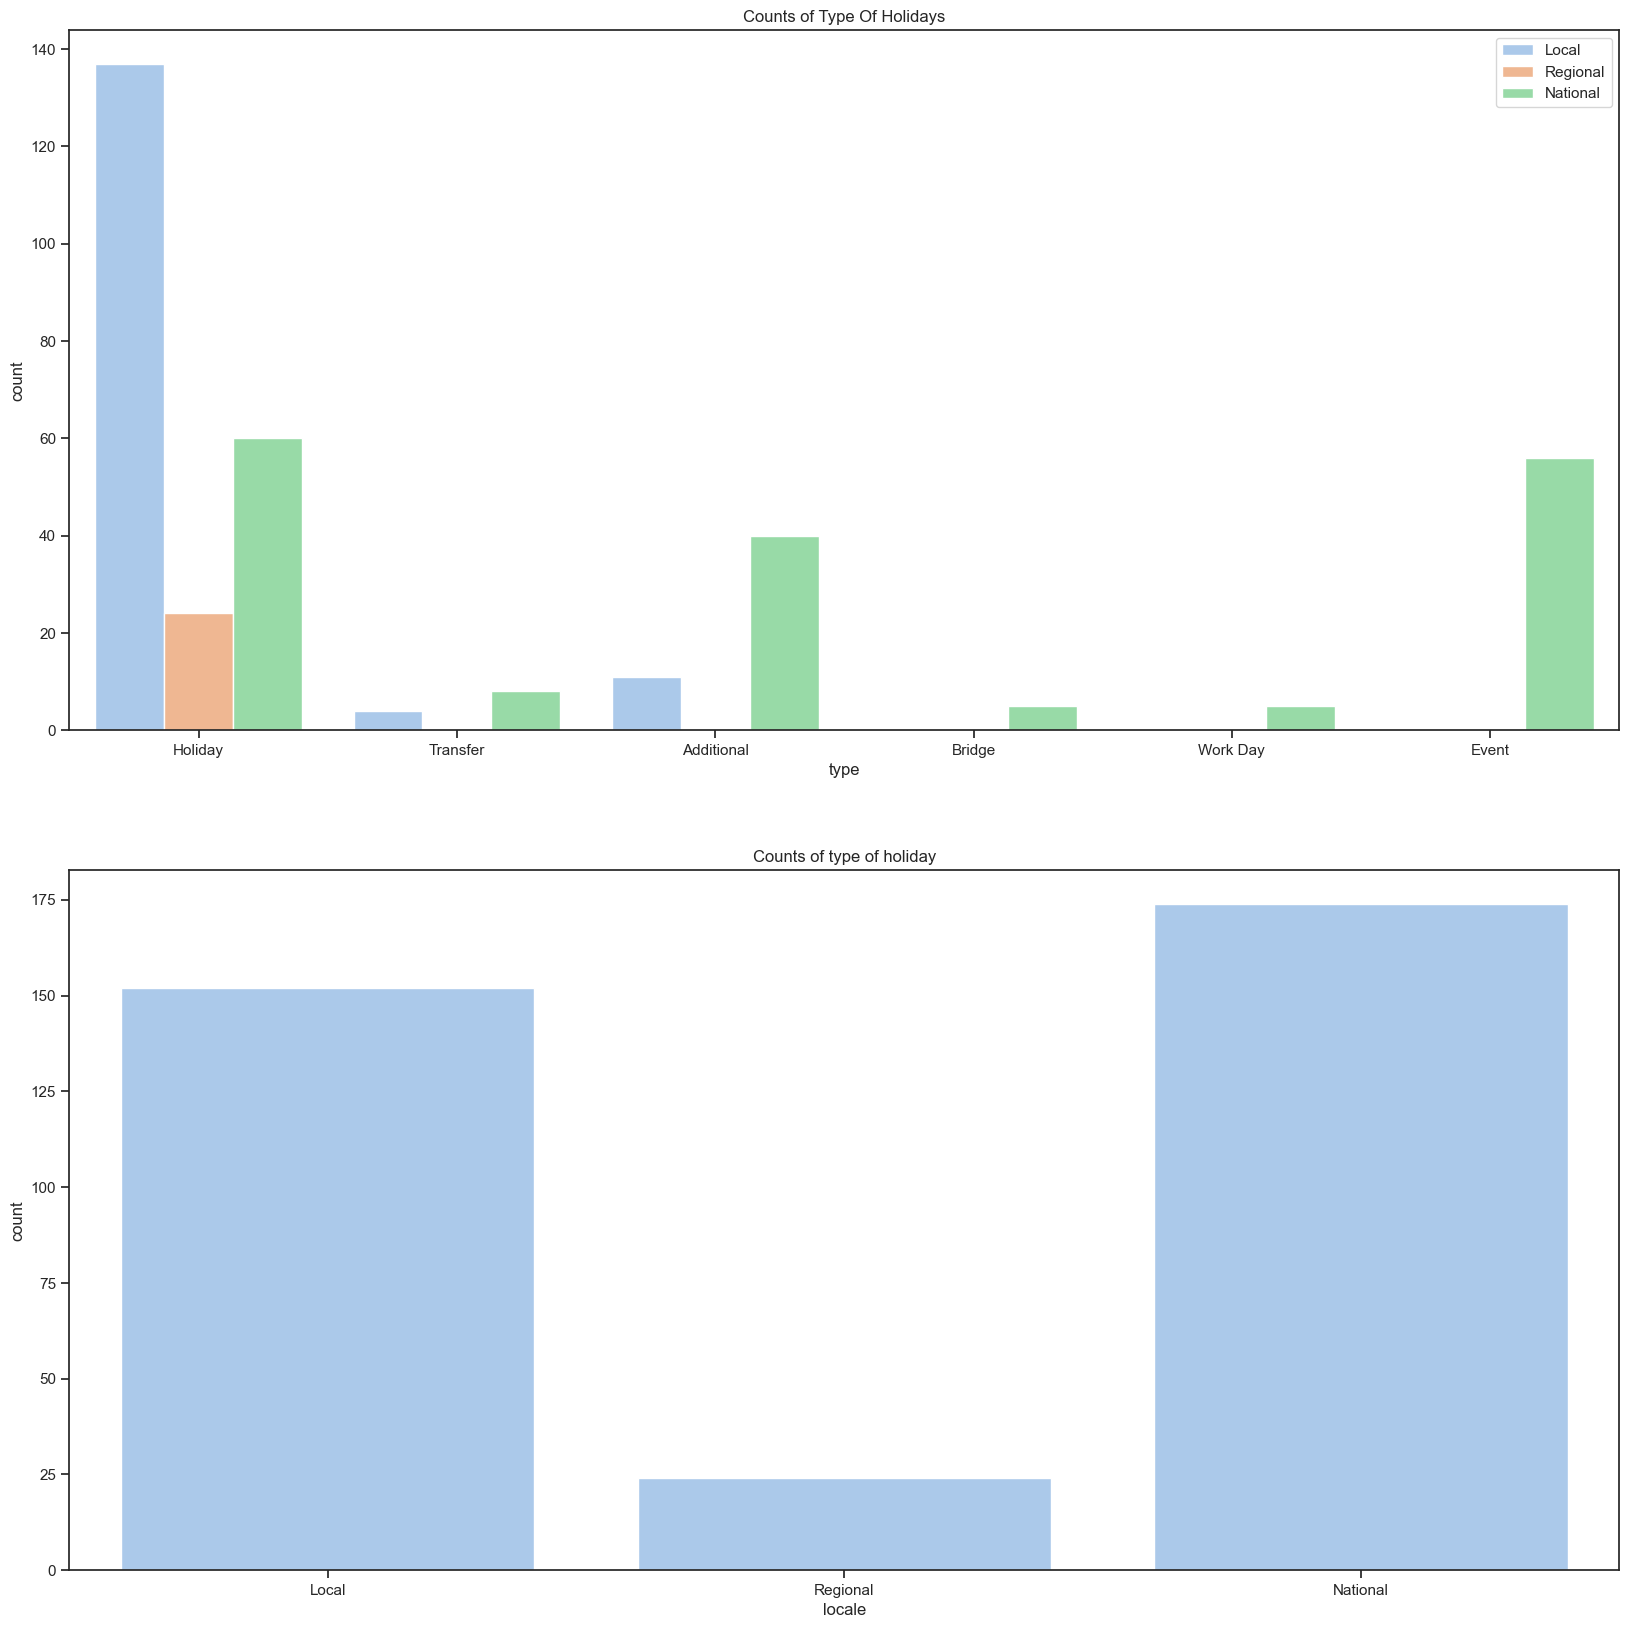

In [63]:
plt.subplots(1,2,figsize=(20,20))
plt.subplot(211)
plt.title('Counts of Type Of Holidays')
sns.countplot(x=df_holidays.type, hue=df_holidays.locale)
plt.legend(loc='upper right')
plt.subplot(212)
plt.title('Counts of type of holiday')
sns.countplot(x=df_holidays.locale)

## Train Data

In [64]:
df_train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [65]:
df_train['date'] = pd.to_datetime(df_train.date)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [66]:
df_train.describe()

,id,date,store_nbr,sales,onpromotion
count,3.000888e+06,3000888,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2015-04-24 08:27:04.703088384,2.750000e+01,3.577757e+02,2.602770e+00
min,0.000000e+00,2013-01-01 00:00:00,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.502218e+05,2014-02-26 18:00:00,1.400000e+01,0.000000e+00,0.000000e+00
50%,1.500444e+06,2015-04-24 12:00:00,2.750000e+01,1.100000e+01,0.000000e+00
75%,2.250665e+06,2016-06-19 06:00:00,4.100000e+01,1.958473e+02,0.000000e+00
max,3.000887e+06,2017-08-15 00:00:00,5.400000e+01,1.247170e+05,7.410000e+02
std,8.662819e+05,NaN,1.558579e+01,1.101998e+03,1.221888e+01


In [67]:
print(set(df_train.family.to_list()))
len(set(df_train.family.to_list()))

{'HOME AND KITCHEN I', 'HOME APPLIANCES', 'PRODUCE', 'LADIESWEAR', 'GROCERY II', 'BOOKS', 'LINGERIE', 'MAGAZINES', 'HARDWARE', 'HOME CARE', 'GROCERY I', 'LAWN AND GARDEN', 'PERSONAL CARE', 'DELI', 'EGGS', 'AUTOMOTIVE', 'BEAUTY', 'BABY CARE', 'SCHOOL AND OFFICE SUPPLIES', 'CLEANING', 'MEATS', 'PET SUPPLIES', 'CELEBRATION', 'BREAD/BAKERY', 'PREPARED FOODS', 'DAIRY', 'LIQUOR,WINE,BEER', 'PLAYERS AND ELECTRONICS', 'BEVERAGES', 'FROZEN FOODS', 'HOME AND KITCHEN II', 'SEAFOOD', 'POULTRY'}


33

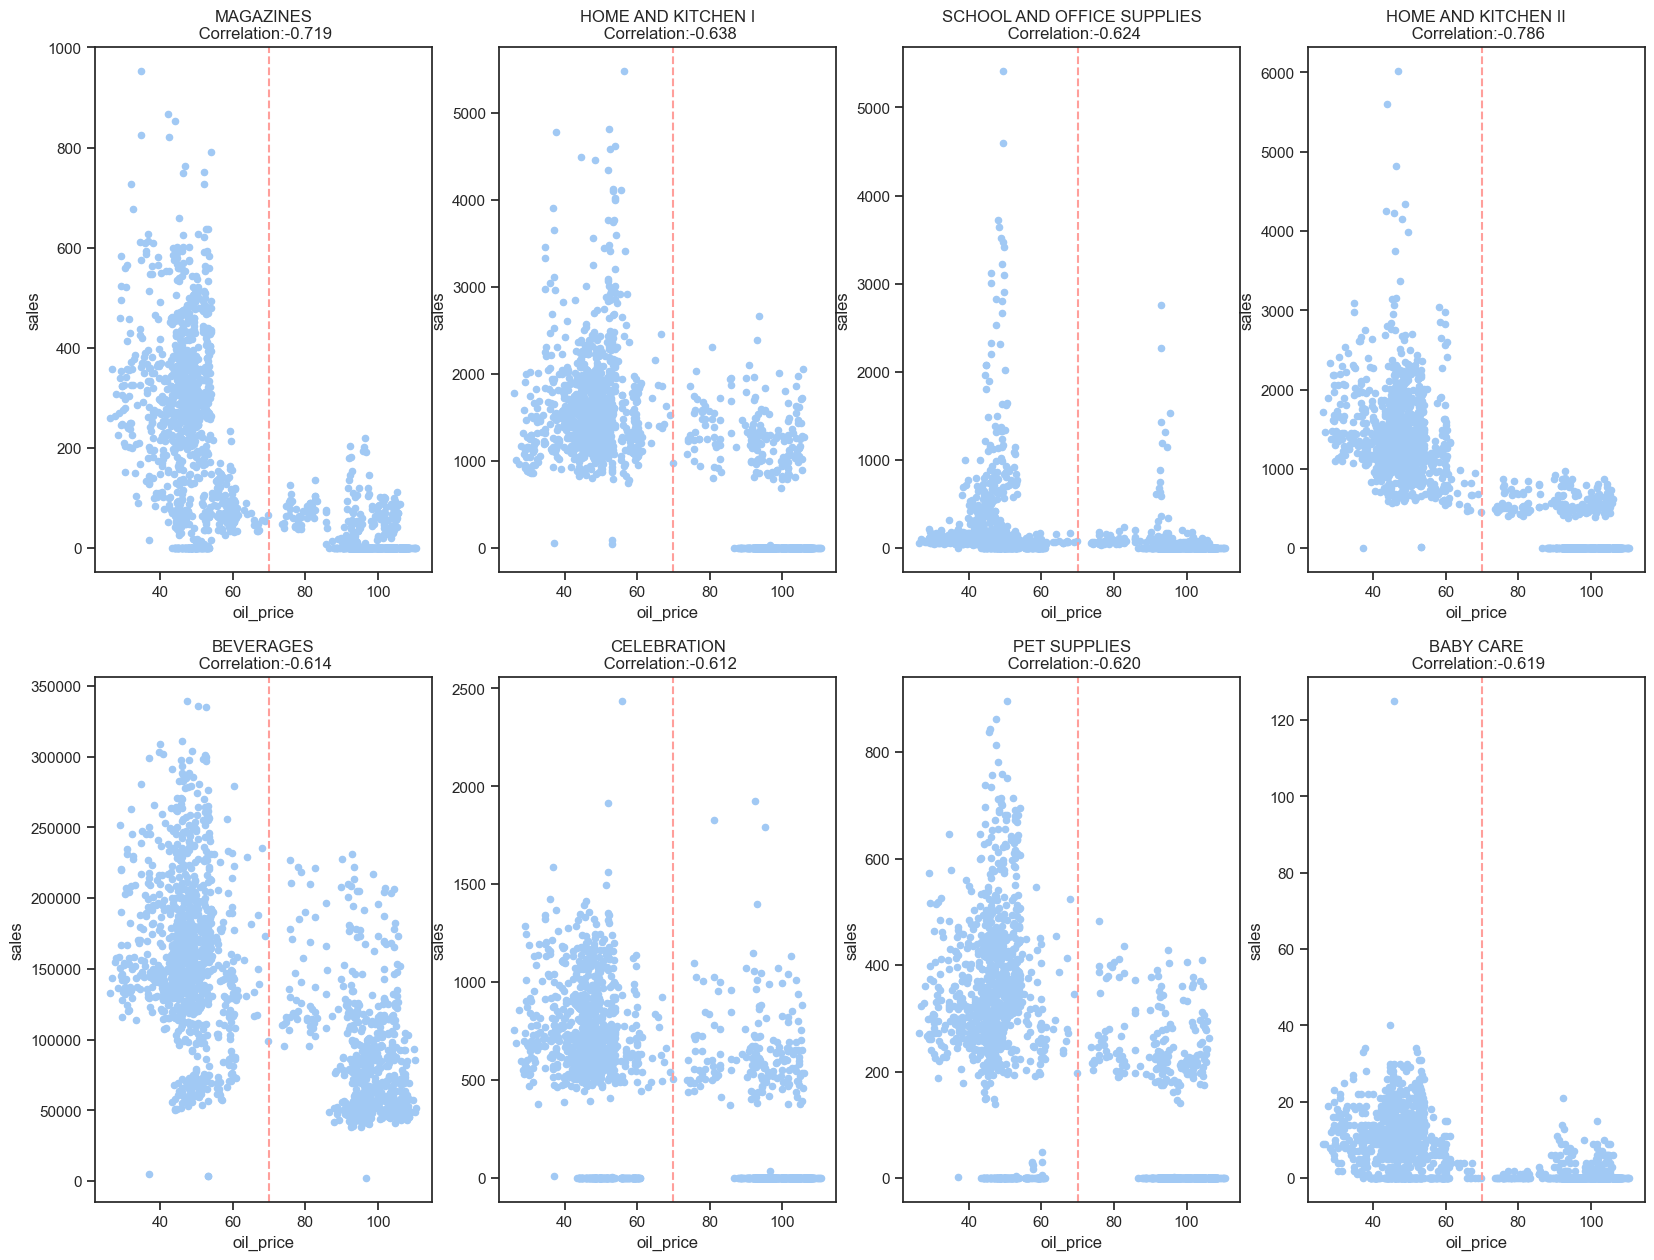

In [69]:
oil = pd.read_csv('originalni_datasetovi/oil.csv')
oil['date'] = pd.to_datetime(oil.date)

# Resample -> index is now date and if there is entry missing for some date it will be 0 for oil_prices
oil = oil.set_index('date').dcoilwtico.resample('D').sum().reset_index()

# Interpolate
oil['dcoilwtico'] = np.where(oil['dcoilwtico'] == 0, np.nan, oil['dcoilwtico'])
oil['oil_price'] = oil.dcoilwtico.interpolate()

# merge train data and oil data
a = pd.merge(df_train.groupby(['date', 'family']).sales.sum().reset_index(), oil.drop('dcoilwtico', axis = 1), how = 'left')
c = a.groupby('family').corr('spearman').reset_index()
c = c[c.level_1 == 'oil_price'][['family', 'sales']].sort_values('sales')

# extract only statisticaly significant correlations
df_significant_corelation = c[(c['sales'] >= 0.6) | (c['sales'] <= -0.6)]
df_significant_corelation

# we make 2x4 matrix of plots
fig, axes = plt.subplots(2, 4, figsize=(20, 15))
for i, family in enumerate(df_significant_corelation.family):
    if i < 4:
         a[a.family == family].plot.scatter(x = 'oil_price', y = 'sales', ax=axes[0, i-1])
         axes[0, i-1].set_title(family+'\n Correlation:'+str(df_significant_corelation[df_significant_corelation.family == family].sales.iloc[0])[:6], fontsize = 12)
         axes[0, i-1].axvline(x=70, color='r', linestyle='--')
    else:
         a[a.family == family].plot.scatter(x = 'oil_price', y = 'sales', ax=axes[1, i-6])
         axes[1, i-6].set_title(family+'\n Correlation:'+str(df_significant_corelation[df_significant_corelation.family == family].sales.iloc[0])[:6], fontsize = 12)
         axes[1, i-6].axvline(x=70, color='r', linestyle='--')

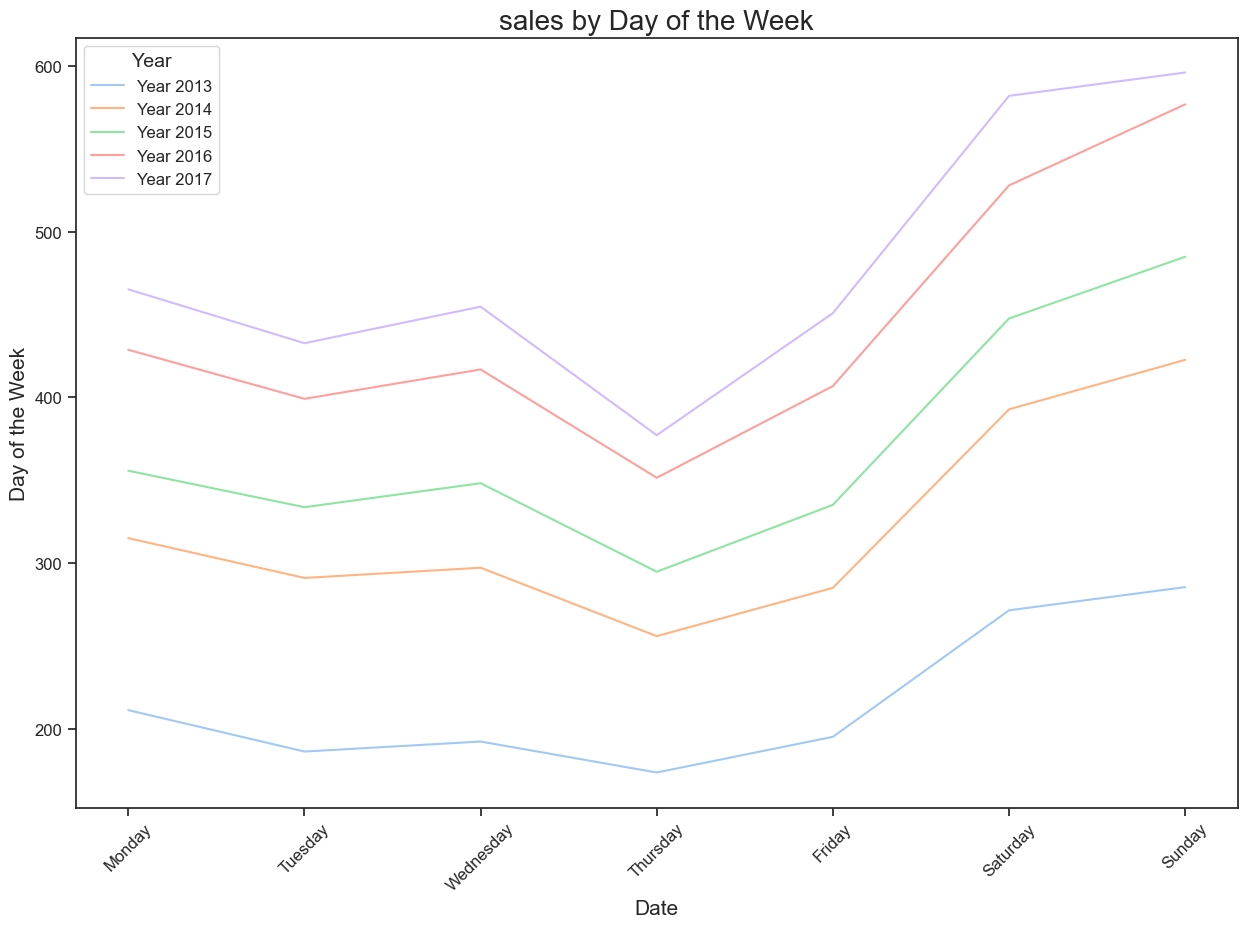

In [35]:
plot_period_mean(df_train, 'sales', period='DW')

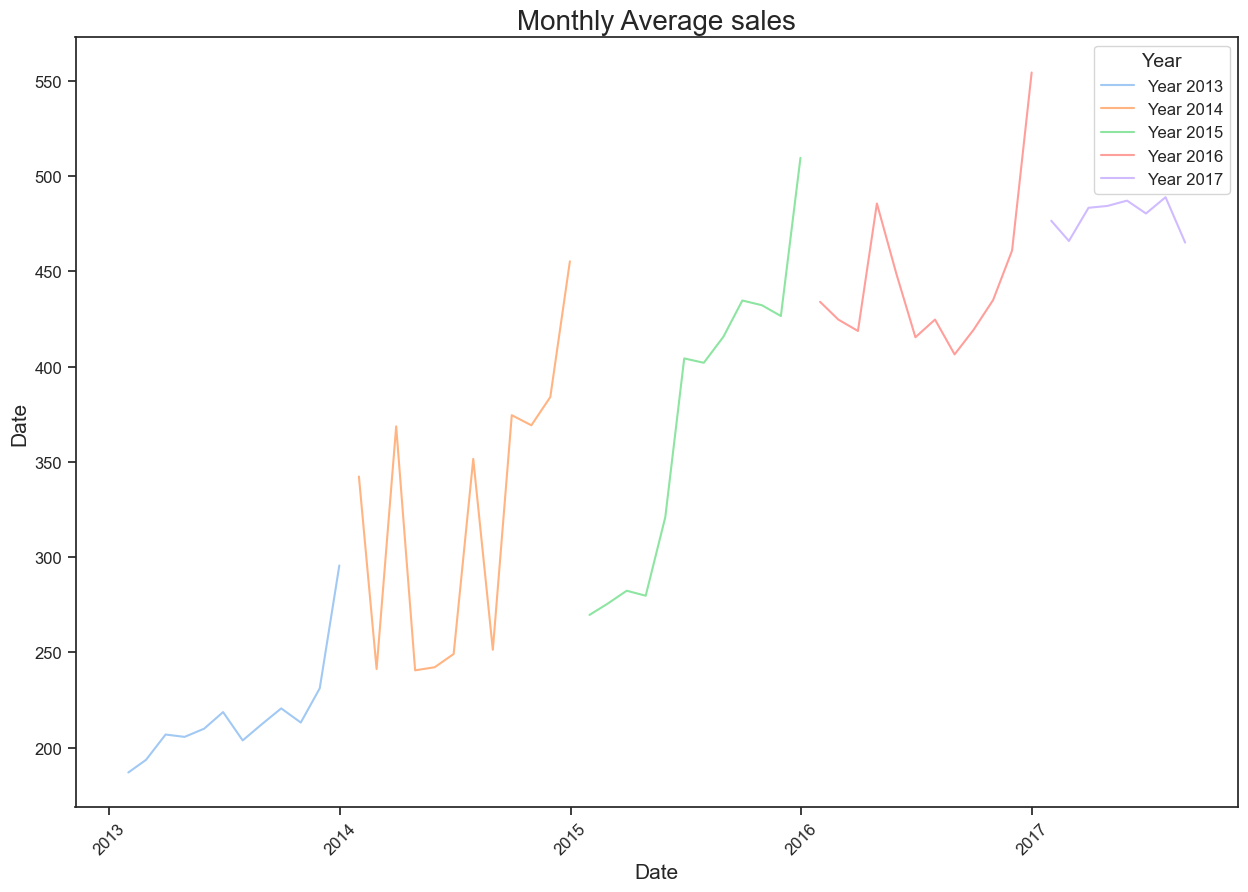

In [36]:
plot_period_mean(df_train, 'sales', period='M')

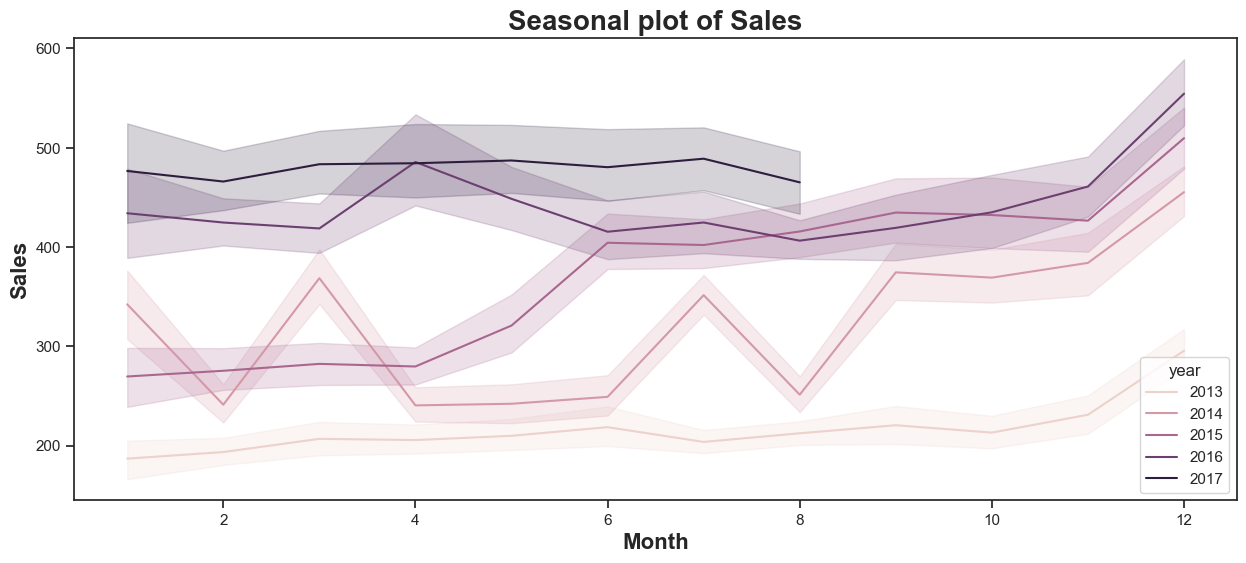

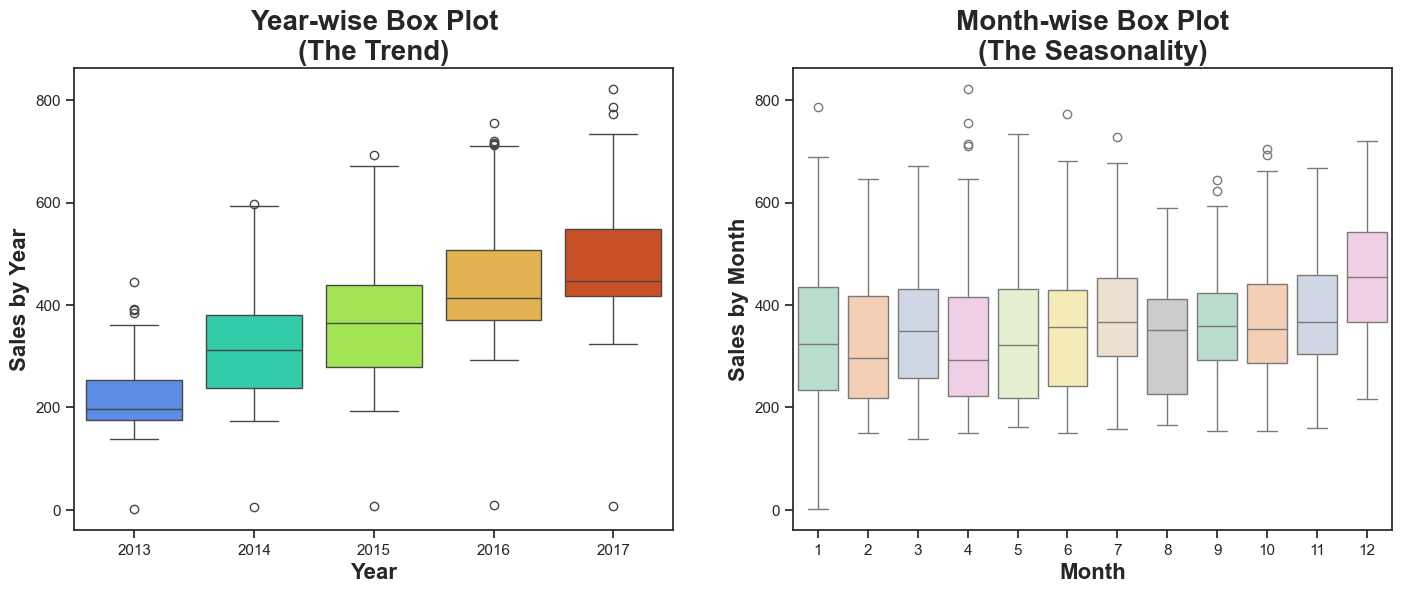

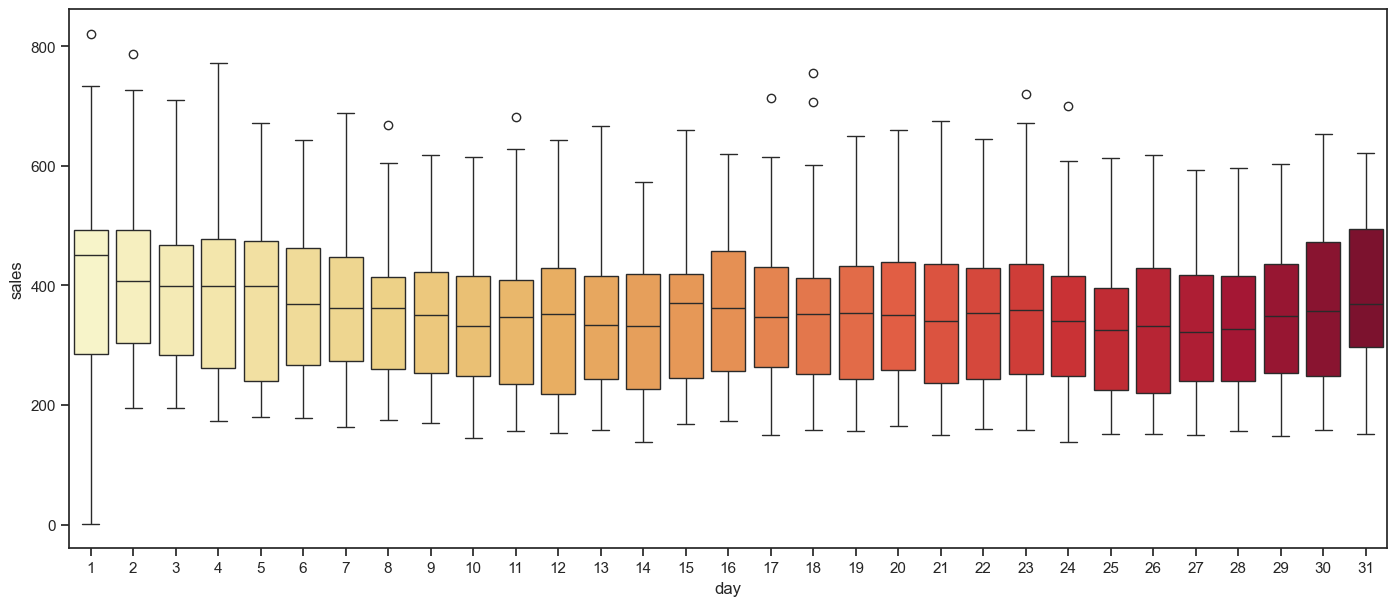

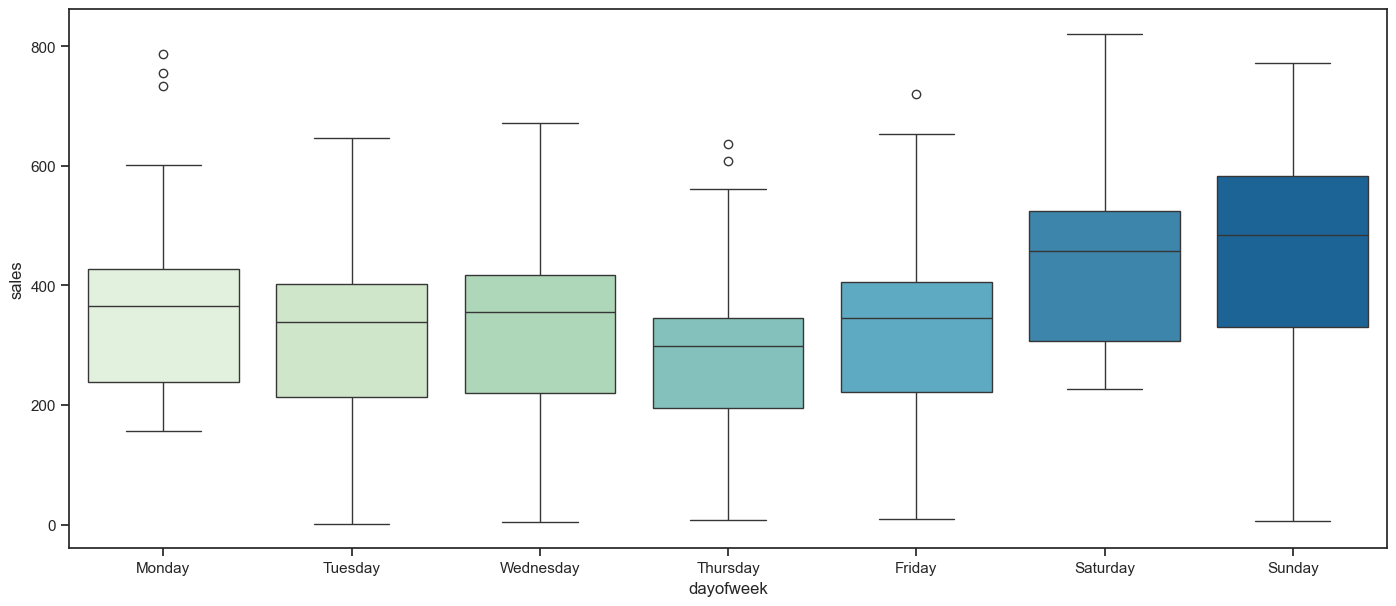

In [37]:
get_seasonality_trend_overview(df_train.drop(columns='family'), 'sales', 'Sales')